In [26]:
import numpy as np
import pandas as pd
import datetime
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from math import sqrt

In [27]:
pd.set_option('display.max_rows', None)

In [28]:
y_train = pd.read_csv('y_train.csv')
y_train = y_train['amount_paid_usd']
y_train = (y_train - np.mean(y_train))/np.std(y_train)

y_valid = pd.read_csv('y_valid.csv')
y_valid = y_valid['amount_paid_usd']
y_valid = (y_valid - np.mean(y_valid))/np.std(y_valid)

In [29]:
X_train = pd.read_csv('X_train.csv')
X_train = X_train.drop(["Unnamed: 0.1", "Unnamed: 0"], axis = 1)

In [30]:
X_valid = pd.read_csv('X_valid.csv')
X_valid = X_valid.drop(["Unnamed: 0.1", "Unnamed: 0"], axis = 1)

In [31]:
utc_datetime = [datetime.datetime.utcfromtimestamp(x) for x in X_train['utc_date']]
utc_datetime_valid = [datetime.datetime.utcfromtimestamp(x) for x in X_valid['utc_date']]

day_month_year = [y.strftime('%a/%d') for y in utc_datetime]
day_month_year_valid = [y.strftime('%a/%d') for y in utc_datetime_valid]

fridays = ['Fri/01', 'Fri/02', 'Fri/03', 'Fri/04', 'Fri/05', 'Fri/06', 'Fri/07']

BC_fridays = [1 if day in fridays else 0 for day in day_month_year]
BC_fridays_valid = [1 if day in fridays else 0 for day in day_month_year_valid]

X_train['BC_fridays'] = BC_fridays
X_valid['BC_fridays'] = BC_fridays_valid

In [32]:
X_train = X_train.drop(['utc_date', 'dateModified', 'datePublished'], axis = 1)
X_valid = X_valid.drop(['utc_date', 'dateModified', 'datePublished'], axis = 1)

In [33]:
num_cols = ['item_price', 'numTracks', 'albumRelease']

for c in num_cols:
    X_train[c] = (X_train[c] - np.mean(X_train[c]))/ np.std(X_train[c])
    X_valid[c] = (X_valid[c] - np.mean(X_valid[c]))/ np.std(X_valid[c])

In [34]:
X = pd.concat([X_train, X_valid])

In [35]:
X['coded_country_code'] = pd.Categorical(X['country_code']).codes
X['coded_currency'] = pd.Categorical(X['currency']).codes
X['coded_genre'] = pd.Categorical(X['Genre']).codes
X['coded_tags'] = pd.Categorical(X["tags"]).codes

In [36]:
X.head()

,item_type,country_code,item_price,currency,numTracks,albumRelease,Genre,inAlbum,tags,BC_fridays,coded_country_code,coded_currency,coded_genre,coded_tags
0,a,au,-0.486125,AUD,-0.028645,-0.378947,rock,is,other,0,9,0,23,23
1,t,nz,-0.725406,GBP,-0.518516,-0.378947,electronic,in,house,0,126,6,9,19
2,a,de,-1.077290,USD,-0.322567,-0.378947,electronic,is,80s,0,40,17,9,0
3,a,nz,-1.077290,USD,1.832862,-0.378947,experimental,is,disco,0,126,17,10,11
4,a,fr,-1.077290,USD,-0.028645,-0.378947,metal,is,other,0,52,17,17,23


In [37]:
X_country = pd.DataFrame()
X_country['country_code'] = np.unique(X['coded_country_code'])
X_country['countries'] = np.unique(X['country_code'])
X_country

,country_code,countries
0,0,ad
1,1,ae
2,2,af
3,3,ag
4,4,al
5,5,am
6,6,an
7,7,ar
8,8,at
9,9,au


In [38]:
X_genre = pd.DataFrame()
X_genre['genre_code'] = np.unique(X['coded_genre'])
X_genre['genre'] = np.unique(X['Genre'])
X_genre

,genre_code,genre
0,0,acoustic
1,1,alternative
2,2,ambient
3,3,audiobooks
4,4,blues
5,5,classical
6,6,comedy
7,7,country
8,8,devotional
9,9,electronic


In [39]:
X_currency = pd.DataFrame()
X_currency['currency_code'] = np.unique(X['coded_currency'])
X_currency['currencies'] = np.unique(X['currency'])
X_currency

,currency_code,currencies
0,0,AUD
1,1,CAD
2,2,CHF
3,3,CZK
4,4,DKK
5,5,EUR
6,6,GBP
7,7,HKD
8,8,HUF
9,9,ILS


In [40]:
X_tags = pd.DataFrame()
X_tags['tags_code'] = np.unique(X['coded_tags'])
X_tags['tags'] = np.unique(X['tags'])
X_tags

,tags_code,tags
0,0,80s
1,1,acid
2,2,acoustic
3,3,alternative
4,4,americana
5,5,bass
6,6,berlin
7,7,blackmetal
8,8,dance
9,9,deathmetal


In [41]:
X_d = X.drop(['country_code', 'currency', 'Genre', 'tags'], axis = 1)
X_d = pd.get_dummies(X_d)

In [42]:
X_train_d = X_d[0:362907]
X_valid_d = X_d[362907:]

In [43]:
X_train_d.head()

,item_price,numTracks,albumRelease,BC_fridays,coded_country_code,coded_currency,coded_genre,coded_tags,item_type_a,item_type_t,inAlbum_in,inAlbum_is,inAlbum_not
0,-0.486125,-0.028645,-0.378947,0,9,0,23,23,1,0,0,1,0
1,-0.725406,-0.518516,-0.378947,0,126,6,9,19,0,1,1,0,0
2,-1.077290,-0.322567,-0.378947,0,40,17,9,0,1,0,0,1,0
3,-1.077290,1.832862,-0.378947,0,126,17,10,11,1,0,0,1,0
4,-1.077290,-0.028645,-0.378947,0,52,17,17,23,1,0,0,1,0


In [44]:
country = X_train_d['coded_country_code']
currency = X_train_d['coded_currency']
genre = X_train_d['coded_genre']
tags = X_train_d['coded_tags']

X_train_d = X_train_d.drop(['coded_country_code', 'coded_currency', 'coded_genre', 'coded_tags'], axis = 1)

In [45]:
country_v = X_valid_d['coded_country_code']
currency_v = X_valid_d['coded_currency']
genre_v = X_valid_d['coded_genre']
tags_v = X_valid_d['coded_tags']

X_valid_d = X_valid_d.drop(['coded_country_code', 'coded_currency', 'coded_genre', 'coded_tags'], axis = 1)

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

In [47]:
#defining input sizes for embedding layers
input_size_country = X['country_code'].nunique()
input_size_currency = X['currency'].nunique()
input_size_genre = X['Genre'].nunique()
input_size_tags = X['tags'].nunique()

In [48]:
def ee_nn(neurons, n_vec_country, n_vec_currency, n_vec_genre, n_vec_tags):
    #defining inputs
    country_input = keras.Input(shape = (1,), name = 'country')
    cur_input = keras.Input(shape = (1,), name = 'curs')
    genre_input = keras.Input(shape = (1,), name = 'genre')
    tags_input = keras.Input(shape = (1,), name = 'tags')
    num_input = keras.Input(shape = X_train_d.shape[1], name = 'num')
    
    #adding the embedding layers
    country_emb = keras.layers.Embedding(input_size_country, n_vec_country, name = 'country_emb')(country_input)
    currency_emb = keras.layers.Embedding(input_size_currency, n_vec_currency, name = 'cur_emb')(cur_input)
    genres_emb = keras.layers.Embedding(input_size_genre, n_vec_genre, name = 'genre_emb')(genre_input)
    tags_emb = keras.layers.Embedding(input_size_tags, n_vec_tags, name = 'tags_emb')(tags_input)
    
    #flatten embedding layers
    flatten_country = keras.layers.Flatten()(country_emb)
    flatten_currs = keras.layers.Flatten()(currency_emb)
    flatten_genres = keras.layers.Flatten()(genres_emb)
    flatten_tags = keras.layers.Flatten()(tags_emb)
    
    #concatenate inputs
    layer = keras.layers.Concatenate()([flatten_country, flatten_currs, flatten_genres, flatten_tags, num_input])
    
    #adding Dense layers
    for n in neurons:
        layer = keras.layers.Dense(n, activation = 'relu')(layer)
    
    layer_out = keras.layers.Dense(1)(layer)
    
    model = keras.Model(inputs = [country_input, cur_input, genre_input, tags_input, num_input], outputs = layer_out)
    model.compile(loss = 'mse', optimizer = 'adam', metrics = 'mse')
    return model

In [49]:
neurons = [128,64,32]
vec_country = [45, 60]
vec_currency = [ 10, 12]
vec_genre = [ 12, 15]
vec_tags = [ 12, 16]

In [50]:
for c in vec_country:
    for cu in vec_currency:
        for g in vec_genre:
            for t in vec_tags:
                emb_mod = ee_nn(neurons, c, cu, g, t)
                print(emb_mod.summary())
                emb_mod.fit([country, currency, genre, tags, X_train_d], y_train, epochs = 8, batch_size = 150)
                pred = emb_mod.predict([country_v, currency_v, genre_v, tags_v, X_valid_d])
                print(sqrt(mean_squared_error(y_valid, pred)))

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 country (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 curs (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 genre (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 tags (InputLayer)              [(None, 1)]          0           []                               
                                                                                           

 concatenate_17 (Concatenate)   (None, 92)           0           ['flatten_68[0][0]',             
                                                                  'flatten_69[0][0]',             
                                                                  'flatten_70[0][0]',             
                                                                  'flatten_71[0][0]',             
                                                                  'num[0][0]']                    
                                                                                                  
 dense_68 (Dense)               (None, 128)          11904       ['concatenate_17[0][0]']         
                                                                                                  
 dense_69 (Dense)               (None, 64)           8256        ['dense_68[0][0]']               
                                                                                                  
 dense_70 

 country (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 curs (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 genre (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 tags (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 country_emb (Embedding)        (None, 1, 45)        8010        ['country[0][0]']                
                                                                                                  
 cur_emb (

                                                                  'flatten_83[0][0]',             
                                                                  'num[0][0]']                    
                                                                                                  
 dense_80 (Dense)               (None, 128)          11648       ['concatenate_20[0][0]']         
                                                                                                  
 dense_81 (Dense)               (None, 64)           8256        ['dense_80[0][0]']               
                                                                                                  
 dense_82 (Dense)               (None, 32)           2080        ['dense_81[0][0]']               
                                                                                                  
 dense_83 (Dense)               (None, 1)            33          ['dense_82[0][0]']               
          

                                                                                                  
 genre (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 tags (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 country_emb (Embedding)        (None, 1, 45)        8010        ['country[0][0]']                
                                                                                                  
 cur_emb (Embedding)            (None, 1, 12)        216         ['curs[0][0]']                   
                                                                                                  
 genre_emb (Embedding)          (None, 1, 15)        405         ['genre[0][0]']                  
          

 dense_92 (Dense)               (None, 128)          12544       ['concatenate_23[0][0]']         
                                                                                                  
 dense_93 (Dense)               (None, 64)           8256        ['dense_92[0][0]']               
                                                                                                  
 dense_94 (Dense)               (None, 32)           2080        ['dense_93[0][0]']               
                                                                                                  
 dense_95 (Dense)               (None, 1)            33          ['dense_94[0][0]']               
                                                                                                  
Total params: 31,960
Trainable params: 31,960
Non-trainable params: 0
__________________________________________________________________________________________________
None
Epoch 1/8
2420/2420 [=============

 tags (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 country_emb (Embedding)        (None, 1, 60)        10680       ['country[0][0]']                
                                                                                                  
 cur_emb (Embedding)            (None, 1, 10)        180         ['curs[0][0]']                   
                                                                                                  
 genre_emb (Embedding)          (None, 1, 12)        324         ['genre[0][0]']                  
                                                                                                  
 tags_emb (Embedding)           (None, 1, 16)        416         ['tags[0][0]']                   
                                                                                                  
 flatten_1

                                                                                                  
 dense_106 (Dense)              (None, 32)           2080        ['dense_105[0][0]']              
                                                                                                  
 dense_107 (Dense)              (None, 1)            33          ['dense_106[0][0]']              
                                                                                                  
Total params: 35,642
Trainable params: 35,642
Non-trainable params: 0
__________________________________________________________________________________________________
None
Epoch 1/8
2420/2420 [==============================] - 4s 1ms/step - loss: 0.3004 - mse: 0.3004
Epoch 2/8
2420/2420 [==============================] - 3s 1ms/step - loss: 0.2908 - mse: 0.2908
Epoch 3/8
2420/2420 [==============================] - 3s 1ms/step - loss: 0.2878 - mse: 0.2878
Epoch 4/8
2420/2420 [======================

                                                                                                  
 cur_emb (Embedding)            (None, 1, 12)        216         ['curs[0][0]']                   
                                                                                                  
 genre_emb (Embedding)          (None, 1, 12)        324         ['genre[0][0]']                  
                                                                                                  
 tags_emb (Embedding)           (None, 1, 12)        312         ['tags[0][0]']                   
                                                                                                  
 flatten_112 (Flatten)          (None, 60)           0           ['country_emb[0][0]']            
                                                                                                  
 flatten_113 (Flatten)          (None, 12)           0           ['cur_emb[0][0]']                
          

 dense_119 (Dense)              (None, 1)            33          ['dense_118[0][0]']              
                                                                                                  
Total params: 36,085
Trainable params: 36,085
Non-trainable params: 0
__________________________________________________________________________________________________
None
Epoch 1/8
2420/2420 [==============================] - 4s 1ms/step - loss: 0.3016 - mse: 0.3016
Epoch 2/8
2420/2420 [==============================] - 3s 1ms/step - loss: 0.2909 - mse: 0.2909
Epoch 3/8
2420/2420 [==============================] - 3s 1ms/step - loss: 0.2880 - mse: 0.2880
Epoch 4/8
2420/2420 [==============================] - 3s 1ms/step - loss: 0.2859 - mse: 0.2859
Epoch 5/8
2420/2420 [==============================] - 3s 1ms/step - loss: 0.2842 - mse: 0.2842
Epoch 6/8
2420/2420 [==============================] - 3s 1ms/step - loss: 0.2829 - mse: 0.2829
Epoch 7/8
2420/2420 [==============================]

 genre_emb (Embedding)          (None, 1, 15)        405         ['genre[0][0]']                  
                                                                                                  
 tags_emb (Embedding)           (None, 1, 16)        416         ['tags[0][0]']                   
                                                                                                  
 flatten_124 (Flatten)          (None, 60)           0           ['country_emb[0][0]']            
                                                                                                  
 flatten_125 (Flatten)          (None, 12)           0           ['cur_emb[0][0]']                
                                                                                                  
 flatten_126 (Flatten)          (None, 15)           0           ['genre_emb[0][0]']              
                                                                                                  
 flatten_1

country: 45, currency: 10, genre: 12, tags: 16

In [51]:
#retrain on train + validation data
y_train = pd.concat([y_train, y_valid])
y_train.shape

(483876,)

In [52]:
X_train = pd.concat([X_train_d, X_valid_d])
X_train.shape

(483876, 9)

In [53]:
X_train.head()

,item_price,numTracks,albumRelease,BC_fridays,item_type_a,item_type_t,inAlbum_in,inAlbum_is,inAlbum_not
0,-0.486125,-0.028645,-0.378947,0,1,0,0,1,0
1,-0.725406,-0.518516,-0.378947,0,0,1,1,0,0
2,-1.077290,-0.322567,-0.378947,0,1,0,0,1,0
3,-1.077290,1.832862,-0.378947,0,1,0,0,1,0
4,-1.077290,-0.028645,-0.378947,0,1,0,0,1,0


In [54]:
X_test = pd.read_csv('X_test.csv')
X_test = X_test.drop(["Unnamed: 0.1", "Unnamed: 0"], axis = 1)

In [55]:
utc_datetime = [datetime.datetime.utcfromtimestamp(x) for x in X_test['utc_date']]

day_month_year = [y.strftime('%a/%d') for y in utc_datetime]


fridays = ['Fri/01', 'Fri/02', 'Fri/03', 'Fri/04', 'Fri/05', 'Fri/06', 'Fri/07']

BC_fridays = [1 if day in fridays else 0 for day in day_month_year]


X_test['BC_fridays'] = BC_fridays
X_test = X_test.drop(['utc_date', 'dateModified', 'datePublished'], axis = 1)

In [56]:
X_test.head()

,item_type,country_code,item_price,currency,numTracks,albumRelease,Genre,inAlbum,tags,BC_fridays
0,a,us,10.0000,USD,11.0,4,folk,is,indie,0
1,t,gb,1.0800,CHF,1.0,1,electronic,not,berlin,0
2,a,ru,2.0000,USD,10.0,1,ambient,is,other,0
3,a,gb,8.2075,EUR,11.0,1,electronic,is,electro,0
4,t,au,1.0900,CHF,1.0,1,electronic,in,other,0


In [57]:
X_test.shape

(120970, 10)

In [58]:
X.head()

,item_type,country_code,item_price,currency,numTracks,albumRelease,Genre,inAlbum,tags,BC_fridays,coded_country_code,coded_currency,coded_genre,coded_tags
0,a,au,-0.486125,AUD,-0.028645,-0.378947,rock,is,other,0,9,0,23,23
1,t,nz,-0.725406,GBP,-0.518516,-0.378947,electronic,in,house,0,126,6,9,19
2,a,de,-1.077290,USD,-0.322567,-0.378947,electronic,is,80s,0,40,17,9,0
3,a,nz,-1.077290,USD,1.832862,-0.378947,experimental,is,disco,0,126,17,10,11
4,a,fr,-1.077290,USD,-0.028645,-0.378947,metal,is,other,0,52,17,17,23


In [59]:
X.shape

(483876, 14)

In [60]:
XX = X.drop(['coded_country_code', 'coded_currency', 'coded_genre', 'coded_tags'], axis = 1)

In [61]:
XXX = pd.concat([XX, X_test])

In [62]:
XXX['coded_country_code'] = pd.Categorical(XXX['country_code']).codes
XXX['coded_currency'] = pd.Categorical(XXX['currency']).codes
XXX['coded_genre'] = pd.Categorical(XXX['Genre']).codes
XXX['coded_tags'] = pd.Categorical(XXX["tags"]).codes

In [63]:
X_train = XXX[:483876]
X_test = XXX[483876:]

In [64]:
country = XXX['coded_country_code']
currency = XXX['coded_currency']
genre = XXX['coded_genre']
tags = XXX['coded_tags']

X_train = X_train.drop(['country_code', 'currency', 'Genre', 'tags', 'coded_country_code', 'coded_currency', 'coded_genre', 'coded_tags'],axis = 1)
X_train.head()

,item_type,item_price,numTracks,albumRelease,inAlbum,BC_fridays
0,a,-0.486125,-0.028645,-0.378947,is,0
1,t,-0.725406,-0.518516,-0.378947,in,0
2,a,-1.077290,-0.322567,-0.378947,is,0
3,a,-1.077290,1.832862,-0.378947,is,0
4,a,-1.077290,-0.028645,-0.378947,is,0


In [65]:
X_train_d = pd.get_dummies(X_train)

In [66]:
X_train_d.shape

(483876, 9)

In [67]:
country_test = X_test['coded_country_code']
currency_test = X_test['coded_currency']
genre_test = X_test['coded_genre']
tags_test = X_test['coded_tags']

X_test = X_test.drop(['country_code', 'currency', 'Genre', 'tags', 'coded_country_code', 'coded_currency', 'coded_genre', 'coded_tags'],axis = 1)
X_test.head()

,item_type,item_price,numTracks,albumRelease,inAlbum,BC_fridays
0,a,10.0000,11.0,4.0,is,0
1,t,1.0800,1.0,1.0,not,0
2,a,2.0000,10.0,1.0,is,0
3,a,8.2075,11.0,1.0,is,0
4,t,1.0900,1.0,1.0,in,0


In [68]:
X_test_d = pd.get_dummies(X_test)
X_test_d.shape

(120970, 9)

In [69]:
num_cols = ['item_price', 'numTracks', 'albumRelease']

for c in num_cols:
    X_test_d[c] = (X_test_d[c] - np.mean(X_test_d[c]))/ np.std(X_test_d[c])

In [70]:
X_test_d.head()

,item_price,numTracks,albumRelease,BC_fridays,item_type_a,item_type_t,inAlbum_in,inAlbum_is,inAlbum_not
0,1.629203,0.436658,2.242001,0,1,0,0,1,0
1,-0.785942,-0.497934,-0.377800,0,0,1,0,0,1
2,-0.536847,0.343198,-0.377800,0,1,0,0,1,0
3,1.143872,0.436658,-0.377800,0,1,0,0,1,0
4,-0.783235,-0.497934,-0.377800,0,0,1,1,0,0


In [71]:
country_train.shape, country_test.shape

NameError: name 'country_train' is not defined

In [73]:
y_train.shape

(483876,)

In [74]:
y_test = pd.read_csv('y_test.csv')
y_test = y_test['amount_paid_usd']
y_test = (y_test - np.mean(y_test))/np.std(y_test)

In [75]:
y_test.shape

(120970,)

In [78]:
def ee_nn(neurons, n_vec_country, n_vec_currency, n_vec_genre, n_vec_tags):
    #defining inputs
    country_input = keras.Input(shape = (1,), name = 'country')
    cur_input = keras.Input(shape = (1,), name = 'curs')
    genre_input = keras.Input(shape = (1,), name = 'genre')
    tags_input = keras.Input(shape = (1,), name = 'tags')
    num_input = keras.Input(shape = X_train_d.shape[1], name = 'num')
    
    #adding the embedding layers
    country_emb = keras.layers.Embedding(input_size_country, n_vec_country, name = 'country_emb')(country_input)
    currency_emb = keras.layers.Embedding(input_size_currency, n_vec_currency, name = 'cur_emb')(cur_input)
    genres_emb = keras.layers.Embedding(input_size_genre, n_vec_genre, name = 'genre_emb')(genre_input)
    tags_emb = keras.layers.Embedding(input_size_tags, n_vec_tags, name = 'tags_emb')(tags_input)
    
    #flatten embedding layers
    flatten_country = keras.layers.Flatten()(country_emb)
    flatten_currs = keras.layers.Flatten()(currency_emb)
    flatten_genres = keras.layers.Flatten()(genres_emb)
    flatten_tags = keras.layers.Flatten()(tags_emb)
    
    #concatenate inputs
    layer = keras.layers.Concatenate()([flatten_country, flatten_currs, flatten_genres, flatten_tags, num_input])
    
    #adding Dense layers
    for n in neurons:
        layer = keras.layers.Dense(n, activation = 'relu')(layer)
    
    layer_out = keras.layers.Dense(1)(layer)
    
    model = keras.Model(inputs = [country_input, cur_input, genre_input, tags_input, num_input], outputs = layer_out)
    model.compile(loss = 'mse', optimizer = 'adam', metrics = 'mse')
    return model

In [72]:
country = XXX['coded_country_code']
currency = XXX['coded_currency']
genre = XXX['coded_genre']
tags = XXX['coded_tags']

country_train = country[:483876]
country_test = country[483876:]

currency_train = currency[:483876]
currency_test = currency[483876:]

genre_train = genre[:483876]
genre_test = genre[483876:]

tags_train = tags[:483876]
tags_test = tags[483876:]

In [77]:
input_size_country = XXX['coded_country_code'].nunique()
input_size_currency = XXX['coded_currency'].nunique()
input_size_genre = XXX['coded_genre'].nunique()
input_size_tags = XXX['coded_tags'].nunique()

In [80]:
neurons = [128,64,32]

emb_mod = ee_nn(neurons, 45, 10, 12, 16)
print(emb_mod.summary())
emb_mod.fit([country_train, currency_train, genre_train, tags_train, X_train_d], y_train, epochs = 8, batch_size = 150)
pred = emb_mod.predict([country_test, currency_test, genre_test, tags_test, X_test_d])
print(sqrt(mean_squared_error(y_test, pred)))

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 country (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 curs (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 genre (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 tags (InputLayer)              [(None, 1)]          0           []                               
                                                                                           

In [81]:
error_df = pd.DataFrame()
error_df['true'] = y_test
error_df['pred'] = pred

In [83]:
error_df['error'] = error_df['true'] - error_df['pred']

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0, 0.5, 'prediction error')

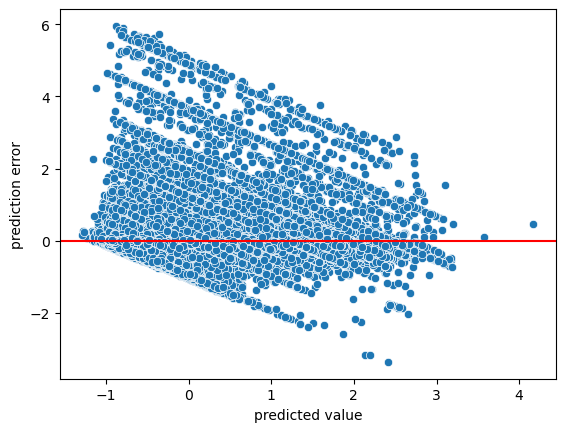

In [85]:
sns.scatterplot(data = error_df, x = 'pred', y = 'error')
plt.axhline(y=0, color = 'r')
plt.xlabel('predicted value')
plt.ylabel('prediction error')

In [87]:
emb_mod.country_emb.get_weights()

AttributeError: 'Functional' object has no attribute 'country_emb'

In [91]:
country_embs = emb_mod.layers[4].get_weights()

In [93]:
country_embs = np.squeeze(country_embs)

In [94]:
country_embs = pd.DataFrame(country_embs)

In [95]:
country_embs

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0.249163,0.188662,-0.230946,0.053696,-0.132424,0.060958,0.170508,0.064250,0.137026,-0.238095,...,-0.149825,0.240883,0.277568,0.463220,0.089338,0.019104,-0.152383,0.027269,0.081353,0.049236
1,-0.148412,-0.078438,0.393168,0.022732,-0.199972,0.096689,0.156891,-0.165636,-0.098211,-0.097623,...,-0.186717,0.281398,-0.481807,0.245335,-0.173919,-0.039289,0.000506,0.113330,-0.166616,-0.021236
2,-0.193973,0.020702,0.135911,-0.121611,-0.026497,-0.110562,0.064336,-0.123145,-0.059353,-0.048265,...,0.121318,0.158556,0.111985,-0.099841,0.087370,-0.013227,-0.008382,-0.106741,0.039618,-0.018419
3,0.072218,0.200550,0.114479,0.078570,0.012329,0.257295,-0.083924,-0.134241,0.128639,-0.027518,...,0.015170,-0.023742,0.119378,-0.029961,-0.055893,0.014266,-0.044712,0.000379,-0.070698,0.009068
4,-0.159636,0.000481,0.097482,-0.079870,-0.075969,-0.107529,-0.174965,0.096273,0.099892,-0.101651,...,-0.123285,0.153198,0.053340,0.116134,0.009502,-0.090766,-0.048114,-0.117911,0.087688,0.187867
5,-0.179058,0.005754,-0.079643,-0.132620,0.067323,0.013974,0.195015,-0.193778,-0.137899,-0.041122,...,-0.040139,0.268411,-0.101774,0.012806,-0.062322,-0.047561,-0.184141,-0.242837,0.074955,-0.059473
6,0.097212,0.147085,0.031117,-0.157853,-0.063755,0.031917,-0.262455,0.130604,0.156202,0.111120,...,0.230905,-0.203438,0.319215,-0.266595,-0.244606,-0.257930,0.170808,0.040055,0.251075,0.157142
7,-0.213242,-0.086255,0.092411,0.182836,-0.005282,-0.054227,-0.008184,-0.284712,-0.196717,-0.135920,...,0.071987,-0.205908,0.133410,0.135301,-0.388291,-0.158301,-0.175884,0.062919,0.137371,0.299139
8,0.044942,-0.034660,-0.026184,-0.043976,0.019962,0.156327,0.083488,-0.000110,0.081752,0.308973,...,-0.100570,-0.028633,-0.097700,0.024187,-0.042643,0.255584,0.067539,-0.029979,0.034285,-0.062583
9,-0.129873,-0.063375,0.108822,0.104387,0.016947,0.123500,0.066032,-0.010314,0.022582,-0.092336,...,-0.042137,-0.090297,-0.053903,0.029363,-0.017794,0.204649,-0.044119,-0.093497,-0.125463,0.029106


In [97]:
currency_embs = emb_mod.layers[5].get_weights()
currency_embs = np.squeeze(currency_embs)
currency_embs = pd.DataFrame(currency_embs)

In [98]:
currency_embs

,0,1,2,3,4,5,6,7,8,9
0,0.190274,-0.199496,-0.328129,0.393958,0.125088,0.022392,-0.326637,-0.137811,-0.206251,-0.153486
1,-0.090518,0.268745,-0.089069,0.359398,0.007618,0.204868,-0.318832,0.134098,-0.152363,-0.312522
2,0.311949,0.203901,-0.103179,0.228278,0.025598,0.067646,0.413540,-0.063726,-0.435209,-0.216231
3,0.315547,-0.068504,0.054870,0.031774,-0.323433,0.205303,-0.006790,-0.361889,-0.191239,0.090237
4,0.067978,-0.438541,0.253754,0.035748,0.293354,0.137928,-0.133459,-0.493001,-0.048366,-0.214961
5,0.004518,-0.000799,0.271408,-0.140963,-0.050264,0.045772,0.223331,-0.237898,-0.267160,-0.202283
6,0.077259,-0.210852,0.153188,0.072211,-0.271447,0.133231,-0.026103,-0.052425,-0.051887,0.209743
7,-0.030433,0.185660,-0.290936,-0.000641,-0.197729,-0.072682,0.462149,-0.021266,-0.028050,0.128817
8,0.257181,-0.369214,-0.136784,-0.036041,-0.066476,0.393393,-0.026721,0.098060,0.096990,0.091907
9,0.311088,-0.010805,-0.239236,0.138725,-0.282317,0.287194,-0.018297,-0.158467,-0.173360,0.267016


In [99]:
genre_embs = emb_mod.layers[6].get_weights()
genre_embs = np.squeeze(genre_embs)
genre_embs = pd.DataFrame(genre_embs)

In [100]:
genre_embs

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.362891,0.003710,0.149570,0.176244,0.100056,-0.180178,0.286106,0.111665,0.008498,-0.102504,-0.215309,0.126563
1,0.067938,0.171568,-0.095105,-0.006631,0.018595,-0.075885,-0.132427,-0.067856,-0.290595,-0.074526,-0.028135,0.078429
2,0.312832,-0.217132,0.206480,0.228380,0.014212,0.182741,-0.252270,-0.190809,-0.061394,0.211932,0.094529,0.021554
3,0.115342,0.486259,-0.290626,0.071691,0.215728,0.006837,0.058920,0.413683,-0.181503,0.173334,-0.086308,0.341558
4,-0.201125,-0.078812,-0.089238,-0.112301,-0.072937,-0.190306,0.142026,-0.119989,-0.135108,0.283438,-0.032223,-0.124823
5,0.012270,0.047733,0.042638,0.002518,0.344358,-0.123830,0.159998,-0.155248,0.415997,-0.067690,0.019888,-0.277568
6,-0.071873,-0.318932,0.414852,-0.162703,-0.120131,0.183606,-0.032371,-0.021097,0.172540,-0.566085,0.058234,-0.400206
7,-0.171118,0.064002,0.085110,0.000356,-0.174756,-0.149581,0.023448,0.347099,-0.231499,-0.020310,-0.326428,0.389981
8,0.160533,-0.210371,0.366163,0.208037,0.370979,-0.041923,0.065705,-0.204601,0.148278,-0.037248,-0.077596,-0.032275
9,0.341291,0.012983,-0.076225,-0.127503,-0.121072,0.206314,-0.083567,0.007031,0.082614,-0.218822,0.210014,-0.107801


In [101]:
tags_embs = emb_mod.layers[7].get_weights()
tags_embs = np.squeeze(tags_embs)
tags_embs = pd.DataFrame(tags_embs)

In [103]:
tags_embs

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.036094,-0.319405,-0.315693,0.066620,-0.101623,-0.035574,0.238883,-0.133753,0.212794,0.110771,0.419664,0.005236,0.104116,-0.064224,0.043841,0.003539
1,0.007470,0.139127,-0.001760,-0.002030,0.199213,0.169547,-0.153057,0.051885,-0.051628,-0.156922,0.447289,0.064180,-0.163005,-0.253056,0.266717,0.063895
2,0.165800,0.280472,0.092842,-0.036905,-0.234468,0.116534,0.124043,-0.070422,-0.013930,0.100201,-0.192698,-0.099838,0.064957,-0.098970,-0.099140,0.151670
3,0.057160,-0.114981,0.125253,-0.119702,-0.005841,-0.390659,-0.130850,-0.202537,-0.075230,0.112407,-0.016721,-0.290313,0.170419,-0.217593,-0.051468,-0.014034
4,0.283295,0.125883,-0.008098,0.056420,-0.215761,0.079274,-0.001782,-0.063969,-0.240177,-0.214288,0.136809,-0.060617,0.157030,-0.297076,0.300924,0.311258
5,-0.013313,-0.245289,-0.474746,-0.198059,0.009738,0.026510,-0.223076,-0.036361,0.027107,-0.319604,0.344655,0.291525,-0.125806,-0.038772,-0.059328,0.001820
6,0.086699,-0.052863,-0.010823,0.214044,-0.193091,0.117880,-0.305878,0.080866,0.289905,0.215182,-0.280810,0.021851,0.094698,0.174465,-0.289972,-0.110509
7,-0.258298,-0.260859,0.005720,0.132607,0.022132,0.272868,-0.098055,-0.109437,-0.096488,0.034749,0.317231,0.301676,-0.020653,0.074836,0.180328,-0.148027
8,-0.239542,0.206286,-0.043639,-0.295660,0.139096,0.058881,0.068620,0.297683,-0.134622,-0.043283,0.066333,-0.170007,-0.184663,0.270095,-0.057078,0.054181
9,-0.245089,-0.139713,0.109940,0.239795,0.362966,0.150130,-0.209782,-0.314337,0.151231,-0.066744,0.151380,0.028598,-0.105378,0.233226,0.122404,0.191450


<Axes: xlabel='0', ylabel='1'>

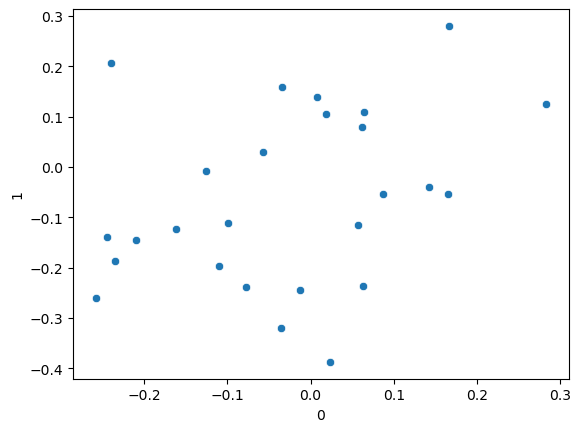

In [111]:
sns.scatterplot(x = tags_embs[0], y = tags_embs[1])